In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import os
import pandas as pd
import plotly.express as px
import sys
import torch
import xml.etree.ElementTree as ET
from pathlib import Path

import load_data
import image

date = datetime.now().strftime("%m-%d-%y")


In [3]:
def read_swc(labels_file):
    print(f"loading file: {labels_file}")
    try:
        with open(labels_file, 'r') as f:
            lines = f.readlines()
    except:
        with open(labels_file, 'r', encoding="latin1") as f:
            lines = f.readlines()

    lines = [line for line in lines if not line.startswith('#') and line.strip()]
    lines = [line.split() for line in lines]
    labels = [list(map(int, line[:2])) + list(map(float, line[2:6])) + [int(line[6])] for line in lines]

    return labels


def load_labels(labels, adjust=True):

    graph = {}
    for parent in labels:
        children = []
        for child in labels:
            if child[6] == parent[0]:
                children.append(child[0])
        graph[parent[0]] = children

    sections = {1:[]}
    section_graph = {1:[]}
    i = 1
    section_id = 1
    for key, value in graph.items():
        if len(value) == 0:
            sections[i] = np.array(sections[i])
            sections[i] = np.stack((sections[i][...,2], sections[i][...,1], sections[i][...,0]), axis=2)
            i = key+1 # go to the section whose first segment corresponds to the next key
            section_id = key+1
            section_graph[section_id] = []
        elif len(value) == 1:
            sections[i].append([labels[key-1][2:5], labels[value[0]-1][2:5]])
        else:
            for child in value:
                if child == key + 1:
                    sections[i].append([labels[key-1][2:5], labels[child-1][2:5]])
                else:
                    sections[child] = []
                    sections[child].append([labels[key-1][2:5], labels[child-1][2:5]])
                    section_graph[section_id].append(child)

    # get average segment length
    lengths = []
    for section in sections.values():
        for segment in section:
            lengths.append(np.linalg.norm(segment[1] - segment[0]))
    avg_length = np.median(lengths)

    branches = []
    terminals = []
    for key, value in graph.items():
        if len(value) == 0:
            terminals.append(labels[key-1][2:5])
        elif len(value) > 1:
            # check the remaining length of each section starting from the current key
            lengths = []
            for child in value:
                # get the last position of each section starting from the current key
                # length = 0
                i = child
                while len(graph[i]) > 0:
                    i += 1
                    # length += 1
                lengths.append(np.linalg.norm(np.array(labels[i-1][2:5]) - np.array(labels[key-1][2:5])))
                # lengths.append(length)
            # if at least two sections have avg_lengths greater than 1, then the current key is a branch
            if key == 1:
                if sum([l > 2*avg_length for l in lengths]) > 2:
                    branches.append(labels[key-1][2:5])
            else:
                if sum([l > 2*avg_length for l in lengths]) > 1:
                    branches.append(labels[key-1][2:5])

    branches = np.array(branches)
    branches = np.stack((branches[:,2], branches[:,1], branches[:,0]), axis=1)
    terminals = np.array(terminals)
    terminals = np.stack((terminals[:,2], terminals[:,1], terminals[:,0]), axis=1)

    scale = 1
    if adjust:
        # scale and shift coordinates
        max = np.array([-1e6, -1e6, -1e6])
        min = np.array([1e6, 1e6, 1e6])
        for id, section in sections.items():
            max = np.maximum(max, section.max(axis=(0,1)))
            min = np.minimum(min, section.min(axis=(0,1)))
        vol = np.prod(max - min)
        scale = np.round((5e7 / vol)**(1/3)) # scale depends on the volume

        for id, section in sections.items():
            section = (section - min) * scale + np.array([10.0, 10.0, 10.0])
            sections[id] = torch.from_numpy(section)
        branches = (branches - min) * scale + np.array([10.0, 10.0, 10.0])
        terminals = (terminals - min) * scale + np.array([10.0, 10.0, 10.0])


    return sections, section_graph, branches, terminals, scale


def draw_neuron_from_swc(labels_file):

    # segments, branches, terminals = load_data.parse_labels(labels_file)
    labels = read_swc(labels_file)
    sections, graph, branches, terminals, scale = load_labels(labels, adjust=True)

    segments = []
    for section in sections.values():
        segments.append(section)
    segments = torch.concatenate(segments)

    shape = torch.ceil(torch.amax(segments, dim=(0,1)))
    shape = shape.to(int) + torch.tensor([10, 10, 10])
    shape = tuple(shape.tolist())

    img = load_data.draw_neuron(segments, shape=shape, width=3, noise=0.05)
    density = load_data.make_neuron_density(segments, shape, width=3)
    section_labels = load_data.make_section_labels(sections, shape, width=6)
    mask = load_data.make_neuron_mask(density, threshold=5.0)

    branch_mask = image.Image(torch.zeros_like(mask))
    for point in branches:
        branch_mask.draw_point(torch.from_numpy(point), radius=3, binary=True, value=1, channel=0)
    # set branch_mask.data to zero where mask is zero
    branch_mask.data = branch_mask.data * mask.data

    # terminal_mask = image.Image(torch.zeros_like(mask))
    # for point in terminals:
    #     terminal_mask.draw_point(torch.from_numpy(point), radius=2, binary=False, value=1, channel=0)
    # # set branch_mask.data to zero where mask is zero
    # terminal_mask.data = terminal_mask.data * mask.data
    seed = sections[1][0,0].round().to(int).tolist()

    swc_data = {"image": img.data,
                "neuron_density": density.data,
                "section_labels": section_labels.data,
                "branch_mask": branch_mask.data,
                "seeds": [seed],
                "scale": scale,
                "graph": graph}

    return swc_data


def save_training_data(labels_dir, outdir, sync=True, random_contrast=False, rng=None):

    if rng is None:
        rng = np.random.default_rng()

    datasets = [dir for dir in os.listdir(labels_dir) if dir[0] != "."]
    outdir_fnames = [g.split('.')[0] for g in os.listdir(outdir)]
    files = []
    for dataset in datasets:
        labels_path = os.path.join(labels_dir, dataset)
        if "CNG version" in os.listdir(labels_path):
            labels_path = labels_path + "/CNG version"
        elif "Source-Version" in os.listdir(labels_path):
            labels_path = labels_path + "/Source-Version"
        else:
            continue

        for f in os.listdir(labels_path):
            if f.endswith("swc") and f[0] != ".":
                if sync:
                    if f.split('.')[0] in outdir_fnames:
                        continue
                files.append(os.path.join(labels_path, f))

    for labels_file in files:
        
        swc_list = load_data.read_swc(labels_file)

        color = np.array([1.0, 1.0, 1.0])
        background = np.array([0., 0., 0.])
        if random_contrast:
            color = rng.uniform(size=3)
            color /= np.linalg.norm(color)
            background = rng.uniform(size=3)
            background = background / np.linalg.norm(background) * 0.01
        swc_data = load_data.draw_neuron_from_swc(swc_list,
                                                  width=3,
                                                  noise=0.0,
                                                  dropout=False,
                                                  adjust=True,
                                                  background_color=background,
                                                  neuron_color=color,
                                                  random_brightness=False,
                                                  binary=False,
                                                  rng=rng)
        scale = swc_data.pop("scale")
        name = os.path.splitext(labels_file.split('/')[-1])[0]
        torch.save(swc_data, os.path.join(outdir, f"{name}_scale_{scale}x.pt"))
        
    return

In [18]:
labels_dir = "/home/brysongray/data/neuromorpho/"
outdir = "/home/brysongray/tractography/data/training_data/neuromorpho_no_artifacts/"
if not os.path.exists(outdir):
    os.makedirs(outdir, exist_ok=True)

save_training_data(labels_dir, outdir=outdir, sync=True, random_contrast=False)

loading file: /home/brysongray/data/neuromorpho/siegert/CNG version/S1_Ovariectomy_Animal01_Trace032.CNG.swc
loading file: /home/brysongray/data/neuromorpho/siegert/CNG version/OB_Adulthood_Control_F_Animal04_Trace056.CNG.swc
loading file: /home/brysongray/data/neuromorpho/buskila/CNG version/MC-Aged-cont-S1.CNG.swc
loading file: /home/brysongray/data/neuromorpho/buskila/CNG version/SSC-Aged-control-S8.CNG.swc
loading file: /home/brysongray/data/neuromorpho/buskila/CNG version/MC-Presymptomatic-SOD1-S3.CNG.swc
loading file: /home/brysongray/data/neuromorpho/buskila/CNG version/MC-Aged-Cont-S2.CNG.swc
loading file: /home/brysongray/data/neuromorpho/buskila/CNG version/SSC-Aged-control-S13.CNG.swc
loading file: /home/brysongray/data/neuromorpho/charlet/CNG version/CeA_Astrocyte_12_003.CNG.swc
loading file: /home/brysongray/data/neuromorpho/charlet/CNG version/CeA_Astrocyte_3_021.CNG.swc
loading file: /home/brysongray/data/neuromorpho/denk/CNG version/orphan_3807.CNG.swc
loading file: /ho

In [4]:
labels_dir = "/home/brysongray/data/neuromorpho/"

datasets = [dir for dir in os.listdir(labels_dir) if dir[0] != "."]
files = []
for dataset in datasets:
    labels_path = os.path.join(labels_dir, dataset)
    if "CNG version" in os.listdir(labels_path):
        labels_path = labels_path + "/CNG version"
    elif "Source-Version" in os.listdir(labels_path):
        labels_path = labels_path + "/Source-Version"
    else:
        continue

    for f in os.listdir(labels_path):
        if f.endswith("swc") and f[0] != ".":
            files.append(os.path.join(labels_path, f))

In [5]:
for i, labels_file in enumerate(files):
    print(i,labels_file)

0 /home/brysongray/data/neuromorpho/mehder/CNG version/Rasha-CA1-Exp-April-2016-right-slide-55-secion-1.CNG.swc
1 /home/brysongray/data/neuromorpho/hart/CNG version/2016-10-27_541_mir-1_day_3_5.CNG.swc
2 /home/brysongray/data/neuromorpho/hart/CNG version/2016-10-27_541_mir-1_day_3_3.CNG.swc
3 /home/brysongray/data/neuromorpho/briggs/CNG version/Bub_9-13_c1.CNG.swc
4 /home/brysongray/data/neuromorpho/quinlan/CNG version/KQa4-12-2015-tracing.CNG.swc
5 /home/brysongray/data/neuromorpho/beining/CNG version/35dpi_ipsi_infra_06.CNG.swc
6 /home/brysongray/data/neuromorpho/kuddannaya/CNG version/Tracetest_N360_semicircle_Map2Tau_79_semi-auto_18.CNG.swc
7 /home/brysongray/data/neuromorpho/chiang/CNG version/Cha-F-000302.CNG.swc
8 /home/brysongray/data/neuromorpho/chiang/CNG version/Cha-F-600090.CNG.swc
9 /home/brysongray/data/neuromorpho/tolias/CNG version/L5MC-J130731a.CNG.swc
10 /home/brysongray/data/neuromorpho/dierssen/CNG version/WT_6mo_3_11.CNG.swc
11 /home/brysongray/data/neuromorpho/bor

In [6]:
i = 23
labels_file = files[i]
print(labels_file)
sections, section_graph, branches, terminals, scale = load_labels(labels_file, adjust=True)
# Create a DataFrame for plotting
data = []
# Iterate through the sections dictionary
for section_id, section_data in sections.items():
    # flatten the section into one list of consecutive points instead of segments (point pairs)
    for segment in section_data:
        point = segment[0] 
        data.append([section_id, point[0].item(), point[1].item(), point[2].item()])
df_sections = pd.DataFrame(data, columns=["section", "x", "y", "z"])

fig = px.line_3d(df_sections, x="x", y="y", z="z", color='section', )
fig.update_layout(scene_aspectmode='data')
fig.show()

/home/brysongray/data/neuromorpho/guizzetti/CNG version/P3_CV3_79.CNG.swc
loading file: /home/brysongray/data/neuromorpho/guizzetti/CNG version/P3_CV3_79.CNG.swc
[1, 1, 0.0, 0.0, 0.0, 6.306, -1]
[2, 1, 2.34, 5.85, 0.0, 6.306, 1]
[3, 1, -2.34, -5.85, 0.0, 6.306, 1]
[4, 6, 1.37, -5.74, 0.9, 0.135, 1]
[5, 6, 1.92, -10.74, 0.9, 0.135, 4]
[6, 6, 0.79, -14.76, 0.9, 0.135, 5]
[7, 6, -0.22, -17.79, 0.9, 0.135, 6]
[8, 6, -4.17, -24.47, 0.9, 0.135, 7]
[9, 6, 2.89, -5.17, 0.75, 0.135, 1]
[10, 6, 9.52, -10.84, 0.75, 0.135, 9]
[11, 6, 12.92, -15.32, 0.75, 0.135, 10]
[12, 6, 15.66, -22.39, 0.75, 0.135, 11]
[13, 6, 15.65, -25.91, 0.75, 0.135, 12]
[14, 6, 17.67, -32.1, 0.75, 0.135, 13]
[15, 6, 17.32, -39.54, 0.75, 0.135, 14]
[16, 6, -4.28, -3.63, 0.75, 0.135, 1]
[17, 6, -6.85, -6.85, 0.75, 0.135, 16]
[18, 6, -11.7, -10.33, 0.75, 0.135, 17]
[19, 6, -6.22, 0.0, 0.75, 0.135, 1]
[20, 6, -11.69, 0.17, 0.75, 0.135, 19]
[21, 6, -15.86, -0.69, 0.75, 0.135, 20]
[22, 6, 5.19, 0.34, 0.75, 0.135, 1]
[23, 6, 8.99,

In [11]:
# labels_file = "/home/brysongray/data/neuromorpho/quinlan/CNG version/KQa4-12-2015-tracing.CNG.swc"

swc_data = draw_neuron_from_swc(labels_file)
density = swc_data["neuron_density"]
branch_mask = swc_data["branch_mask"]
section_labels = swc_data["section_labels"]
name = "KQa4-12-2015-tracing.CNG"

# density_np = density.data.squeeze(0).numpy()
# niiobj = nib.Nifti1Image(density_np, affine=np.eye(4))
# nib.save(niiobj, f'/home/brysongray/tractography/neuron_trx/training_data/{name}_scale-{scale}x.nii.gz')

# branches_np = branch_mask.data.squeeze().numpy()
# niiobj = nib.Nifti1Image(branches_np, affine=np.eye(4))
# nib.save(niiobj, f'/home/brysongray/tractography/neuron_trx/training_data/{name}_scale-{scale}x_branches.nii.gz')

# terminals_np = terminal_mask.data.squeeze().numpy()
# niiobj = nib.Nifti1Image(terminals_np, affine=np.eye(4))
# nib.save(niiobj, f'/home/brysongray/tractography/neuron_trx/training_data/{name}_scale-{scale}x_terminals.nii.gz')

loading file: /home/brysongray/data/neuromorpho/guizzetti/CNG version/P3_CV3_79.CNG.swc


In [12]:
density.shape

torch.Size([1, 116, 869, 642])

In [14]:
segments = []
for section in sections.values():
    segments.append(section)
segments = torch.cat(segments)

In [17]:
segments = segments.flatten(0,1)
segments.shape

torch.Size([80, 3])

In [18]:
print(segments.amax(dim=0))
print(segments.amin(dim=0))

tensor([105.6000, 858.7000, 631.3000], dtype=torch.float64)
tensor([10., 10., 10.], dtype=torch.float64)


In [126]:
section_labels_np = section_labels.squeeze().numpy()
np.unique(section_labels_np)

array([  0,   1,  37,  46,  49,  70,  72,  84, 119, 136, 174, 190, 194,
       244, 264, 281, 314, 363, 405, 407, 460, 498, 516, 545, 547, 600,
       615, 655, 681, 682, 685, 713, 715, 746, 777, 798], dtype=uint16)

In [131]:
section_labels.shape

torch.Size([1, 248, 524, 519])

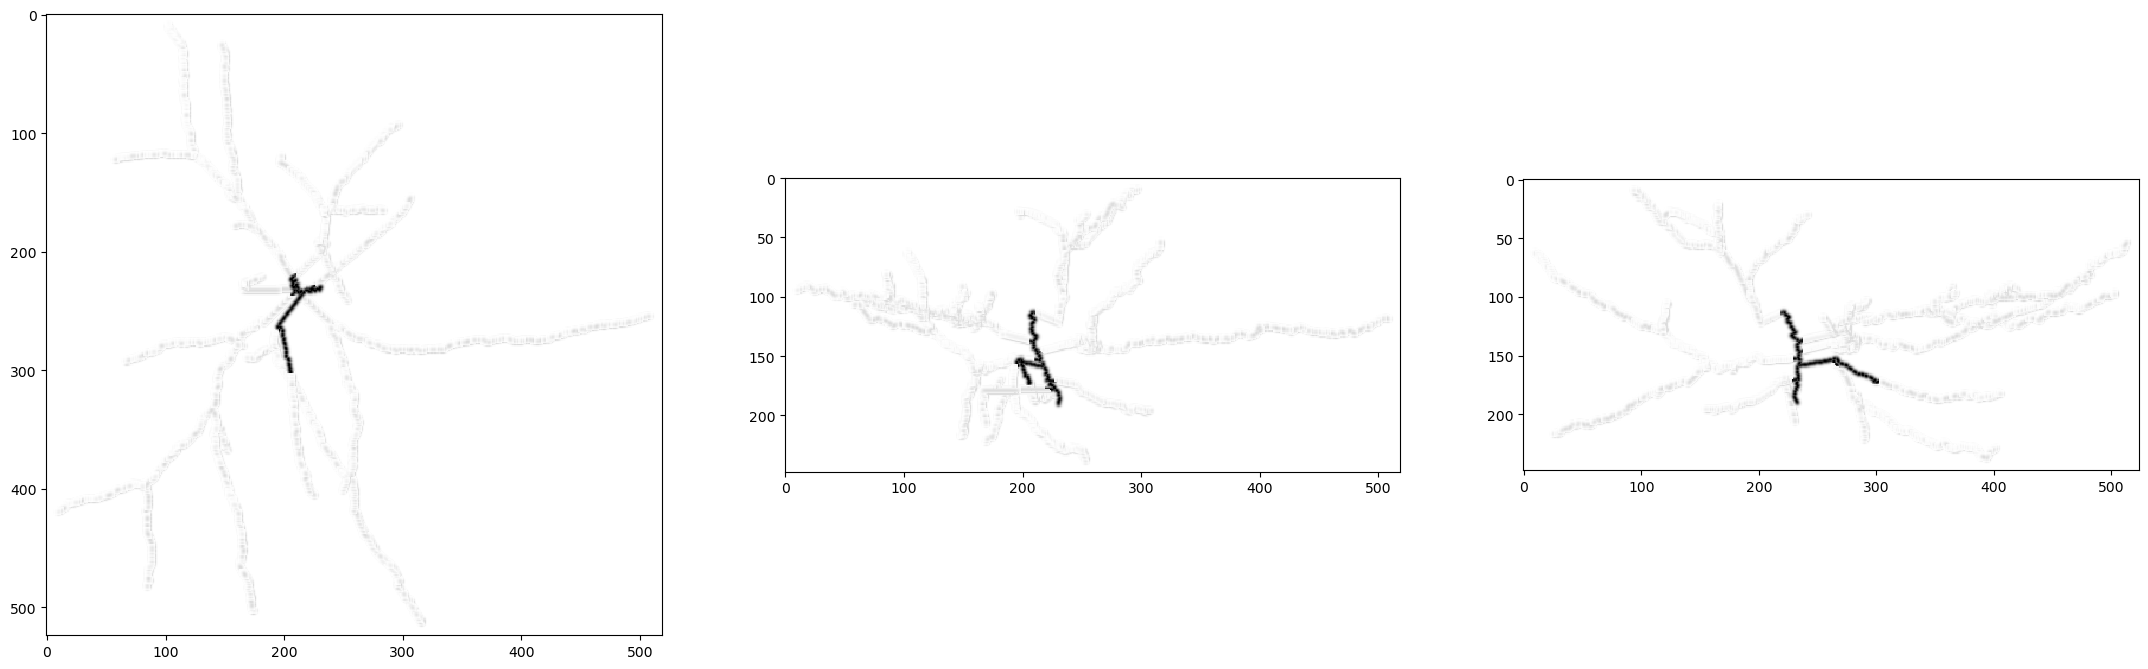

In [158]:
# get pixels where section label is 1 or 37
section_1 = torch.where(section_labels.squeeze() == 0, 1, 0)
section_2 = torch.where(section_labels.squeeze() == 72, 1, 0)
# section_3 = torch.where(section_labels.squeeze() == 136, 1, 0)
section_4 = torch.where(section_labels.squeeze() == 1, 1, 0)
section = section_1 + section_4 + section_2
density_masked = density.data.squeeze() * section
fig, ax = plt.subplots(1, 3, figsize=(27, 18))
ax[0].imshow(density_masked.amax(axis=0), cmap='binary', interpolation="none")
ax[1].imshow(density_masked.amax(axis=1), cmap='binary', interpolation="none")
ax[2].imshow(density_masked.amax(axis=2), cmap='binary', interpolation="none")

In [44]:
labels_file = "/home/brysongray/data/neuromorpho/roysam/CNG version/farsight879.CNG.swc"
img, density, branch_mask, seed, scale = draw_neuron_from_swc(labels_file)

loading file: /home/brysongray/data/neuromorpho/roysam/CNG version/farsight879.CNG.swc


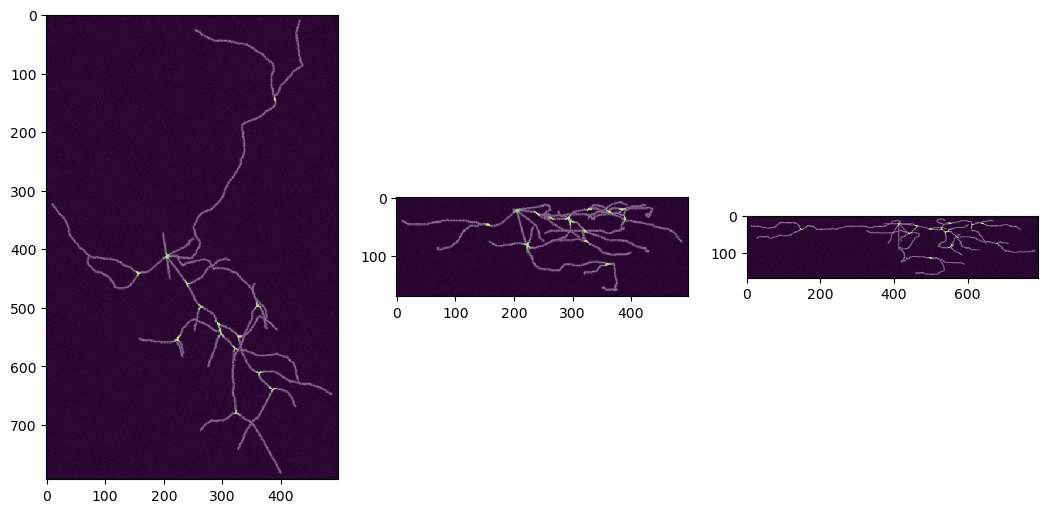

In [45]:
fig, ax = plt.subplots(1,3, figsize=plt.rcParams["figure.figsize"]*np.array([2.0,2.0]))
ax = ax.ravel()
for i in range(3):
    ax[i].imshow(branch_mask.data[0].amax(i), interpolation="none")
    ax[i].imshow(img.data[0].amax(i), cmap='gray', interpolation="none", alpha=0.5)

In [ ]:
branch_label = nib.load('/home/brysongray/tractography/neuron_trx/training_data/branch_pts.nii.gz')
branch_label_data = branch_label.get_fdata()
idxs = np.argwhere(branch_label_data > 0)
idxs

FileNotFoundError: No such file or no access: '/home/brysongray/tractography/neuron_trx/training_data/branch_pts_scale-6x.nii.gz'

In [ ]:
np.round(terminals_adjusted).astype(int).tolist()

[[61, 79, 116],
 [58, 86, 123],
 [53, 98, 132],
 [54, 97, 148],
 [61, 100, 134],
 [45, 104, 136],
 [52, 104, 131],
 [48, 111, 133],
 [32, 114, 115],
 [34, 116, 117],
 [37, 115, 116],
 [17, 113, 104],
 [30, 112, 113],
 [32, 113, 114],
 [32, 112, 113],
 [46, 101, 87],
 [50, 105, 94],
 [30, 101, 82],
 [25, 129, 46],
 [20, 127, 70],
 [21, 128, 63],
 [25, 129, 68],
 [27, 125, 70],
 [29, 119, 68],
 [32, 121, 68],
 [31, 127, 64],
 [36, 119, 53],
 [36, 112, 10],
 [32, 106, 33],
 [37, 104, 35],
 [36, 108, 45],
 [41, 105, 32],
 [54, 97, 47],
 [61, 78, 35],
 [55, 74, 41],
 [44, 71, 40],
 [40, 74, 44],
 [39, 87, 56],
 [12, 72, 141],
 [20, 73, 131],
 [22, 75, 132],
 [31, 92, 153],
 [34, 87, 158],
 [38, 84, 142],
 [33, 60, 122],
 [16, 95, 127],
 [13, 86, 124],
 [17, 89, 116],
 [28, 76, 104],
 [28, 74, 99],
 [36, 65, 102],
 [14, 79, 85],
 [12, 79, 85],
 [11, 74, 95],
 [17, 77, 97],
 [21, 69, 95],
 [42, 10, 63],
 [35, 14, 70],
 [41, 21, 76],
 [47, 21, 77],
 [45, 21, 80],
 [37, 43, 110],
 [33, 35, 92],

In [6]:
# read xml file
tree = ET.parse('/home/brysongray/tractography/neuron_trx/training_data/astro-1_scale-3x_seeds.xml')
seeds = []
for elem in tree.iter():
    voxel_position = elem.get('voxelposition')
    if voxel_position:
        voxel_position = list(map(int, voxel_position.split()))
        seeds.append(voxel_position)

seeds

[[16, 116, 10],
 [16, 151, 33],
 [15, 77, 44],
 [15, 44, 57],
 [14, 114, 44],
 [13, 131, 57],
 [16, 153, 60],
 [17, 156, 64],
 [20, 142, 85],
 [18, 199, 73],
 [19, 172, 94],
 [14, 149, 135],
 [14, 138, 116],
 [14, 94, 110],
 [17, 44, 99],
 [19, 74, 80],
 [17, 49, 76],
 [17, 66, 69],
 [13, 10, 103]]

In [29]:
tree = ET.parse('/home/brysongray/tractography/neuron_trx/training_data/Aged_mice_VAC-PBS10_58-DG-1.CNG_scale-3x_manual_branches.xml')
branches = []
for elem in tree.iter():
    voxel_position = elem.get('voxelposition')
    if voxel_position:
        voxel_position = list(map(int, voxel_position.split()))
        branches.append(voxel_position)
branches = np.array(branches)

branch_mask = image.Image(torch.zeros_like(mask))
for point in branches:
    branch_mask.draw_point(torch.from_numpy(point), radius=3, binary=False, value=1, channel=0)
# set branch_mask.data to zero where mask is zero
branch_mask.data = branch_mask.data * mask.data
# set the new mask to maximum(mask.data, branch_mask.data)
mask_and_branches = torch.maximum(mask.data, branch_mask.data)

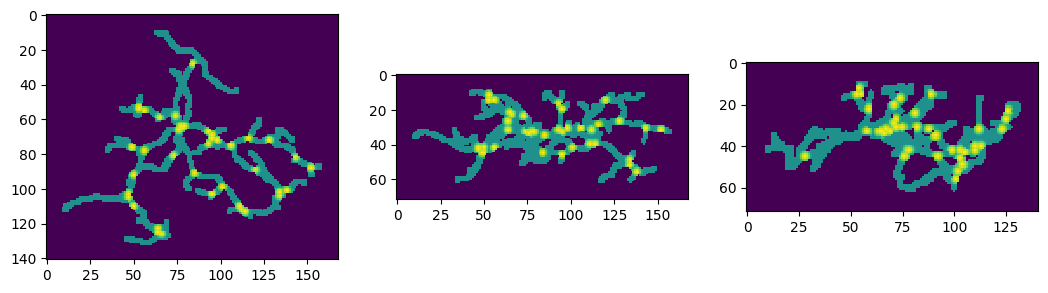

In [27]:
fig, ax = plt.subplots(1,3, figsize=plt.rcParams["figure.figsize"]*np.array([2.0,2.0]))
ax = ax.ravel()
for i in range(3):
    ax[i].imshow(mask_and_branches.data[0].amax(i), interpolation="none")

In [30]:
neuron = {"image": img.data, "neuron": density.data, "neuron_mask": branch_mask.data}
torch.save(neuron, f"/home/brysongray/tractography/neuron_trx/training_data/neuromorpho/{name}_scale-{scale}.pt")

In [42]:
os.listdir("/home/brysongray/tractography/data/training_data/neuromorpho_with_artifacts")

['SN_Adulthood_Control_M_Animal08_Trace005.CNG_scale_6.0x.pt',
 'skel_20220_sorted.CNG_scale_1.0x.pt',
 'SN_5xFAD_6mpos_M_Animal03_Trace033.CNG_scale_8.0x.pt',
 '1-CTR_2w_Female_Nac_6.CNG_scale_10.0x.pt',
 'FC_Development_P15_M_Animal02_Trace109.CNG_scale_9.0x.pt',
 'CeA_Astrocyte_3_021.CNG_scale_32.0x.pt',
 'SD3.CNG_scale_25.0x.pt',
 '14dpi_WT2_S6_2.CNG_scale_8.0x.pt',
 'C242-01-08-14-B1.CNG_scale_2.0x.pt',
 '20160916_BGUG_HuC_ltRFP_d7_F13.CNG_scale_9.0x.pt',
 '2016-10-27_541_mir-1_day_3_5.CNG_scale_21.0x.pt',
 'cort4c4pg1d.CNG_scale_6.0x.pt',
 'CN_Development_P22_F_Animal03_Trace009.CNG_scale_9.0x.pt',
 'P3_CV3_79.CNG_scale_10.0x.pt',
 'S1_CKp25_1w_M_Animal02_Trace067.CNG_scale_10.0x.pt',
 'SN_Ovariectomy_Animal02_Trace052.CNG_scale_11.0x.pt',
 'MC-Aged-Cont-S2.CNG_scale_15.0x.pt',
 'L5MC-J130731a.CNG_scale_1.0x.pt',
 'S1_5xFAD_3mpos_M_Animal03_Trace037.CNG_scale_10.0x.pt',
 'FC_Development_P22_F_Animal03_Trace164.CNG_scale_6.0x.pt',
 'Cell_134_MPD_12_FT_10_XYZ_Sorted-swc_N3DFix-swc_

/tmp/ipykernel_43084/1470601058.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("/home/brysongray/tractography/data/training_data/neuromorpho_no_artifa

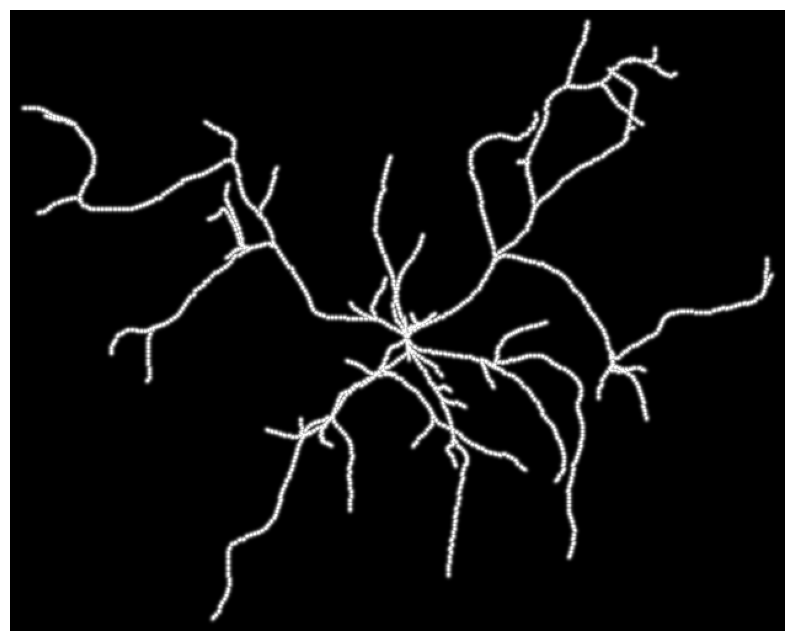

In [50]:
data = torch.load("/home/brysongray/tractography/data/training_data/neuromorpho_no_artifacts/S1_Ovariectomy_Animal01_Trace032.CNG_scale_8.0x.pt")
img = data["image"]

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(img.amax(dim=3).permute(1,2,0))
ax.axis('off')
plt.savefig(f"S1_Ovariectomy_Animal01_Trace032.CNG_scale_8.0x_no_artifacts.png")


In [44]:
img.shape

torch.Size([3, 505, 630, 183])

In [4]:
for i in range(67):
    ep_snapshot_fpath = f"/home/brysongray/tractography/outputs_test/episode_snapshots_neurom_with_artifacts_01-26-25/ep_snapshot_{i}.pt"
    ep_snapshot = torch.load(ep_snapshot_fpath, weights_only=True)
    print(i, ep_snapshot["coverage"])

0 0.3750562369823456
1 0.05746553838253021
2 0.5022709965705872
3 0.0448143407702446
4 0.0017497813096269965
5 0.9374555945396423
6 0.43927446007728577
7 0.6552239060401917
8 0.845698893070221
9 0.14979079365730286
10 0.8166238069534302
11 0.7311379909515381
12 0.6710595488548279
13 0.06312499940395355
14 0.6157873272895813
15 0.05289256200194359
16 0.015384615398943424
17 0.6799879670143127
18 0.4498269855976105
19 0.19645608961582184
20 0.4000000059604645
21 0.15078900754451752
22 0.012529833242297173
23 0.026416702196002007
24 0.1827957034111023
25 0.2502168118953705
26 0.2969072163105011
27 0.7212178707122803
28 0.5353497266769409
29 0.015587530098855495
30 0.6989160776138306
31 0.8895599842071533
32 0.370631605386734
33 0.4311809539794922
34 0.24936805665493011
35 0.5090262293815613
36 0.4463050663471222
37 0.32256779074668884
38 0.16889147460460663
39 0.16243870556354523
40 0.022737819701433182
41 0.638390064239502
42 0.7172306776046753
43 0.43293091654777527
44 0.511811733245849

In [24]:
for i in range(67):
    ep_snapshot_fpath = f"/home/brysongray/tractography/outputs_test/episode_snapshots_neurom_no_artifacts_01-26-25/ep_snapshot_{i}.pt"
    ep_snapshot = torch.load(ep_snapshot_fpath, weights_only=True)
    print(i, ep_snapshot["coverage"])

0 0.6637167930603027
1 0.8986878991127014
2 0.8959121704101562
3 0.2332906574010849
4 0.7255560159683228
5 0.5398074984550476
6 0.9786780476570129
7 0.5279295444488525
8 0.5299684405326843
9 0.9723880887031555
10 0.0036318355705589056
11 0.7008368372917175
12 0.9271636605262756
13 0.7972071766853333
14 0.21484375
15 0.9093305468559265
16 0.6363003253936768
17 0.6680862307548523
18 0.7449923157691956
19 0.0037735849618911743
20 0.7340736389160156
21 0.0008949880721047521
22 0.28504472970962524
23 0.5990143418312073
24 0.42844751477241516
25 0.6254295706748962
26 0.80922931432724
27 0.6718336343765259
28 0.88968825340271
29 0.0016057807952165604
30 0.8770492076873779
31 0.003526771441102028
32 0.8177570104598999
33 0.5790746212005615
34 0.5678701400756836
35 0.18283581733703613
36 0.8488835692405701
37 0.7370864748954773
38 0.5580899715423584
39 0.7090487480163574
40 0.6439628601074219
41 0.6234927773475647
42 0.3031522333621979
43 0.5358281135559082
44 0.86388099193573
45 0.129230767488

In [100]:
name = "neurom_with_artifacts"
i=53
# ep_snapshot_fpath = f"/home/brysongray/tractography/outputs_test/episode_snapshots_Astro-1_11-18-24/ep_snapshot_34.pt"
# ep_snapshot_fpath = f"/home/brysongray/tractography/outputs_test/episode_snapshots_neurom_dataset_1_11-26-24/ep_snapshot_{i}.pt"
ep_snapshot_fpath = f"/home/brysongray/tractography/outputs_test/episode_snapshots_neurom_with_artifacts_01-26-25/ep_snapshot_{i}.pt"
ep_snapshot = torch.load(ep_snapshot_fpath, weights_only=True)
labeled_neuron, true_neuron, global_recall, ep_return = ep_snapshot.values()

# outdir = f'/home/brysongray/tractography/neuron_trx/predicted_path_niftis_{date}_with_artifacts/'
# if not os.path.isdir(outdir):
#     os.makedirs(outdir, exist_ok=True)

# label_np = labeled_neuron.squeeze().cpu().numpy()
# niiobj = nib.Nifti1Image(label_np, affine=np.eye(4))
# nib.save(niiobj, os.path.join(outdir, f'{name}_predicted_{i}.nii.gz'))

# true_np = true_neuron.squeeze().cpu().numpy()
# niiobj = nib.Nifti1Image(true_np, affine=np.eye(4))
# nib.save(niiobj, os.path.join(outdir, f'{name}_true_label_{i}.nii.gz'))

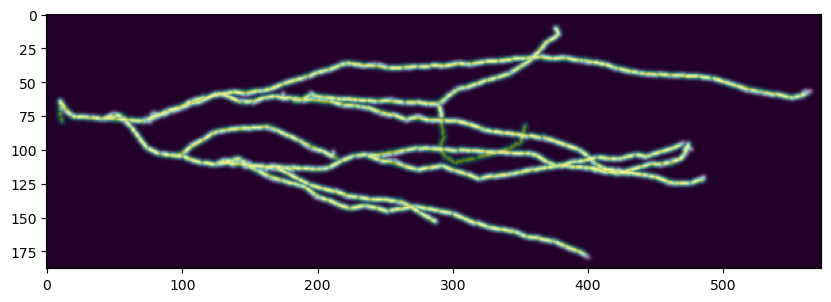

In [101]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(true_neuron.amax(2))
ax.imshow(labeled_neuron.amax(2), cmap="gray", alpha=0.5)

In [102]:
name = "neurom_no_artifacts"
i=48
# ep_snapshot_fpath = f"/home/brysongray/tractography/outputs_test/episode_snapshots_Astro-1_11-18-24/ep_snapshot_34.pt"
# ep_snapshot_fpath = f"/home/brysongray/tractography/outputs_test/episode_snapshots_neurom_dataset_1_11-26-24/ep_snapshot_{i}.pt"
ep_snapshot_fpath = f"/home/brysongray/tractography/outputs_test/episode_snapshots_neurom_no_artifacts_01-26-25/ep_snapshot_{i}.pt"
ep_snapshot = torch.load(ep_snapshot_fpath, weights_only=True)
labeled_neuron, true_neuron, global_recall, ep_return = ep_snapshot.values()

# outdir = f'/home/brysongray/tractography/neuron_trx/predicted_path_niftis_{date}_no_artifacts/'
# if not os.path.isdir(outdir):
#     os.makedirs(outdir, exist_ok=True)

# label_np = labeled_neuron.squeeze().cpu().numpy()
# niiobj = nib.Nifti1Image(label_np, affine=np.eye(4))
# nib.save(niiobj, os.path.join(outdir, f'{name}_predicted_{i}.nii.gz'))

# true_np = true_neuron.squeeze().cpu().numpy()
# niiobj = nib.Nifti1Image(true_np, affine=np.eye(4))
# nib.save(niiobj, os.path.join(outdir, f'{name}_true_label_{i}.nii.gz'))

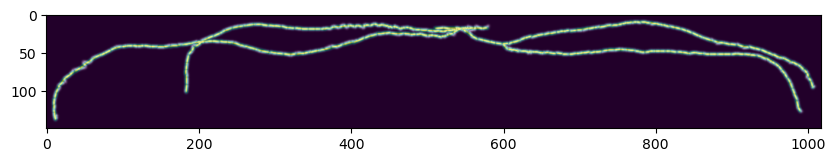

In [103]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(true_neuron.amax(2))
ax.imshow(labeled_neuron.amax(2), cmap="gray", alpha=0.5)

In [6]:
data = torch.concatenate((torch.ones((labeled_neuron[0].shape[0],1)), labeled_neuron[0]), dim=1)

df_sections = pd.DataFrame(data, columns=["section", "x", "y", "z"])

fig = px.line_3d(df_sections, x="x", y="y", z="z", color='section', )
fig.update_layout(scene_aspectmode='data')
fig.show()

ValueError: Shape of passed values is (470, 402), indices imply (470, 4)

In [ ]:
I = torch.zeros((1,25,25))

segment = torch.tensor([[16.3, 11.2],
                        [15.4, 10.5]])
xI = [torch.arange(s) for s in I.shape[1:]]
XI = torch.stack(torch.meshgrid(xI, indexing='ij'), dim=-1)

# get the distance from each point in XI to the closest point in the segment
dist = torch.



In [49]:
XI

tensor([[[ 0,  0],
         [ 0,  1],
         [ 0,  2],
         ...,
         [ 0, 22],
         [ 0, 23],
         [ 0, 24]],

        [[ 1,  0],
         [ 1,  1],
         [ 1,  2],
         ...,
         [ 1, 22],
         [ 1, 23],
         [ 1, 24]],

        [[ 2,  0],
         [ 2,  1],
         [ 2,  2],
         ...,
         [ 2, 22],
         [ 2, 23],
         [ 2, 24]],

        ...,

        [[22,  0],
         [22,  1],
         [22,  2],
         ...,
         [22, 22],
         [22, 23],
         [22, 24]],

        [[23,  0],
         [23,  1],
         [23,  2],
         ...,
         [23, 22],
         [23, 23],
         [23, 24]],

        [[24,  0],
         [24,  1],
         [24,  2],
         ...,
         [24, 22],
         [24, 23],
         [24, 24]]])